In [255]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:80% !important;} </style>"))

In [256]:
! pip install umap-learn
! pip install speechbrain==0.5.15


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [257]:
import os
import random
import torch
import umap
import zipfile
import librosa
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
import torchaudio
import plotly.graph_objects as go
from   tqdm          import tqdm
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Audio
from IPython.display import Image
from IPython.display import HTML
from speechbrain.pretrained import EncoderClassifier
# from google.colab import drive
# drive.mount('/content/drive')

In [258]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU or CPU.
DEVICE

device(type='cuda', index=0)

In [259]:
TARGET_SR = 16000

In [260]:
hack_group_name = "group4"

<h1 style="background-color:#4CAF50;"> <center> Get the Data </center> </h1>

In [261]:
data_folder = '/home/eyalshw/github/wzudemy/hakol/data/subset'
print(os.path.exists(data_folder))
audio_files_path  = os.path.join(data_folder, "wav_files_subset")
print(os.path.exists(audio_files_path))
challenge_folder = '/home/eyalshw/github/wzudemy/hakol/data/challenge'
if not os.path.exists(challenge_folder):
    os.makedirs(challenge_folder)
# TODO: Place the file: groups_challenge.csv in challenge_folder

True
True


<h1 style="background-color:#4CAF50;"> <center> Load Train Dataset </center> </h1>

In [262]:
TRAIN_CSV = os.path.join(data_folder,"hackathon_train_subset.csv")
train_df = pd.read_csv(TRAIN_CSV)
print(f"Number of utterances: {train_df.shape[0]}")
train_df.head()

Number of utterances: 74


,language,file,speaker,noise_type
0,russian,2006849.wav,3191,comm
1,russian,3018610.wav,3191,clean
2,russian,7608580.wav,3191,background
3,russian,4426066.wav,3191,comm
4,russian,8924221.wav,3191,background


<span style="font-size: larger;"> How many unique speakers are there?

In [263]:
unique_speakers = len(train_df['speaker'].unique())
print(f"There are {unique_speakers} unique speakers")

There are 5 unique speakers


<span style="font-size: larger;"> Analyze Columns:

In [264]:
def plot_column_analysis(column):
    # Count the occurrences of each language
    language_counts = train_df[column].value_counts()

    # Group by 'language' and count the number of unique speakers for each language
    unique_speakers = train_df.groupby(column)['speaker'].nunique()

    # Sort the indices
    language_counts = language_counts.sort_index()
    unique_speakers = unique_speakers.sort_index()

    # Create the bar plots
    fig1 = px.bar(language_counts,
                  x=language_counts.index,
                  y=language_counts.values,
                  text=language_counts.values,
                  labels={'x': column, 'y': 'Count'})

    fig2 = px.bar(unique_speakers,
                  x=unique_speakers.index,
                  y=unique_speakers.values,
                  text=unique_speakers.values,
                  labels={'x': column, 'y': 'number of Unique Speakers'})

    # Customize the layout
    fig1.update_layout(showlegend=False)
    fig2.update_layout(showlegend=False)

    # Customize the text on the bars
    fig1.update_traces(texttemplate='%{text}', textposition='outside')
    fig2.update_traces(texttemplate='%{text}', textposition='outside')

    # Create a subplot
    fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                        subplot_titles=(f'{column} counts', f'Number of unique speakers per {column}'))

    # Add the bar plots to the subplot
    fig.add_trace(fig1['data'][0], row=1, col=1)
    fig.add_trace(fig2['data'][0], row=1, col=2)

    # Customize the layout of the subplot
    fig.update_layout(title=f'{column.upper()} Analysis', width=1000, height=600)

    fig.show()


In [265]:
plot_column_analysis("language")

In [266]:
plot_column_analysis("noise_type")

<span style="font-size: larger;"> Listen to a random utterance in arabic:

In [267]:
random_row        = train_df[train_df.language == "arabic"].sample(n=1)
speaker           = random_row['speaker'].iloc[0]
utterance         = random_row['file'].iloc[0]
noise_type        = random_row['noise_type'].iloc[0]
print(f"Noise Type: {noise_type}")
anchor_utterance  = os.path.join(audio_files_path,utterance)
Audio(anchor_utterance)

Noise Type: comm


<span style="font-size: larger;"> Listen to another utterance from the same speaker:

In [268]:
random_other_row = train_df[train_df.speaker == speaker].sample(n=1)
other_utterance  = random_other_row['file'].iloc[0]
while utterance == other_utterance:
    # Make sure that other_utterance is a different one
    random_other_row = train_df[train_df.speaker == speaker].sample(n=1)
    other_utterance  = random_other_row['file'].iloc[0]
noise_type = random_other_row['noise_type'].iloc[0]
print(f"Noise Type: {noise_type}")
lang = random_other_row['language'].iloc[0]
print(f"Language: {lang}")
other_utterance = os.path.join(audio_files_path,random_other_row['file'].iloc[0])
Audio(other_utterance)

Noise Type: comm
Language: arabic


<span style="font-size: larger;"> Plot the 2 utterances from above:

In [269]:
def plot_utterance(utterance_path):
    print(f"This is '{utterance_path}':")
    array, sampling_rate = librosa.load(utterance_path)

    # Create a 1x2 subplot for side by side figures
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    # Waveform plot on the first axis
    librosa.display.waveshow(array, sr=sampling_rate, ax=ax[0], color='blue')
    ax[0].set_title("Waveform")

    # Mel spectrogram plot on the second axis
    S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000, ax=ax[1])
    ax[1].set_title("Mel Spectrogram")

    # Colorbar for the mel spectrogram
    fig.colorbar(img, ax=ax[1])

    plt.tight_layout()
plt.show()

This is '/home/eyalshw/github/wzudemy/hakol/data/subset/wav_files_subset/6541755.wav':


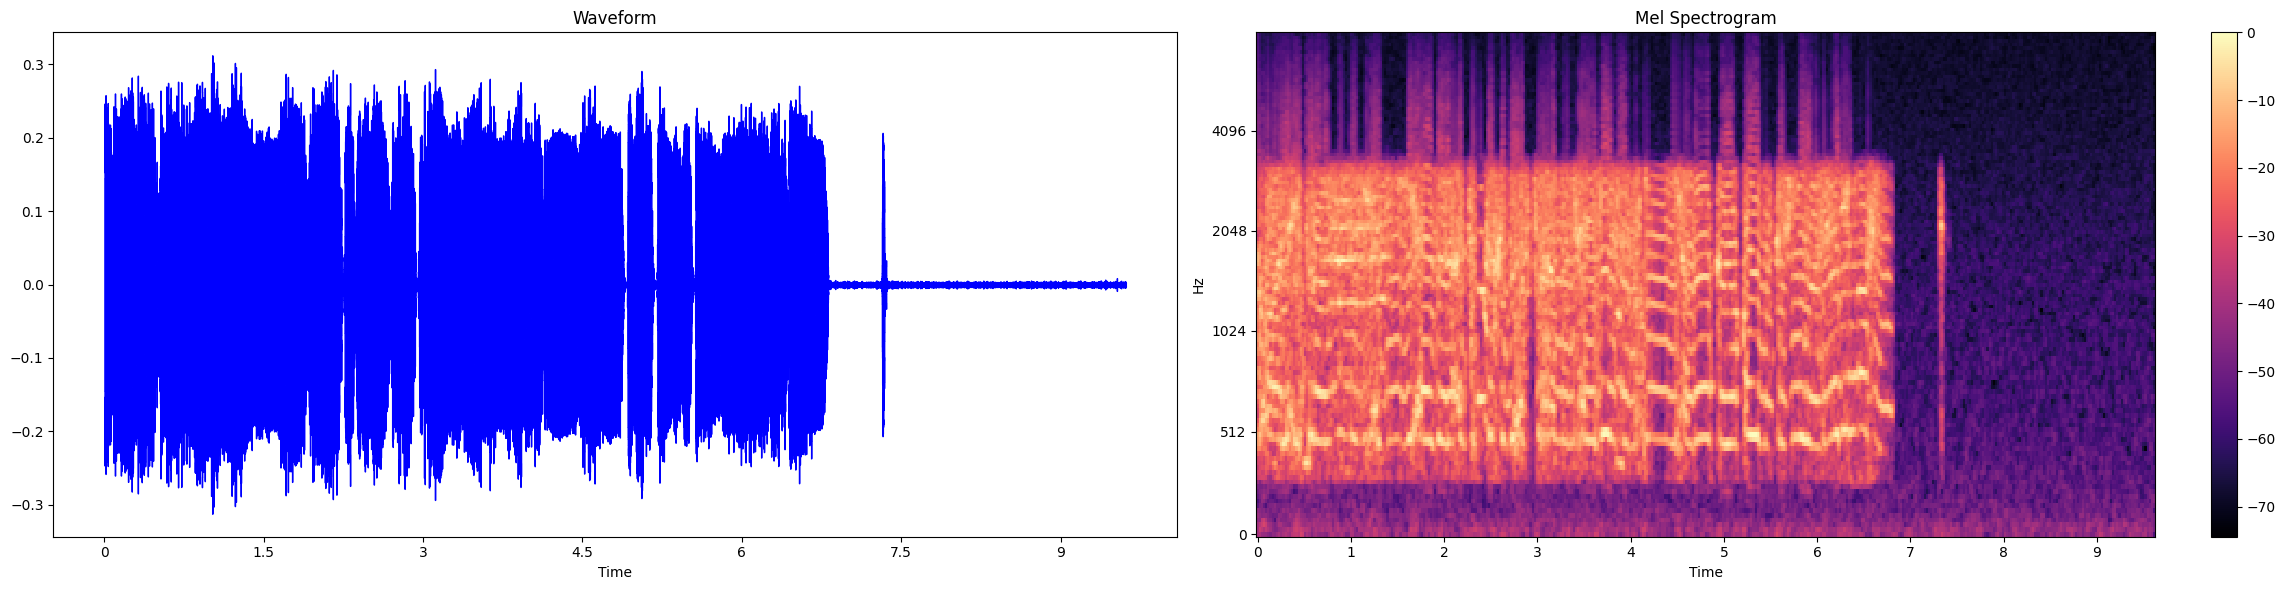

In [270]:
plot_utterance(anchor_utterance)

This is '/home/eyalshw/github/wzudemy/hakol/data/subset/wav_files_subset/5374064.wav':


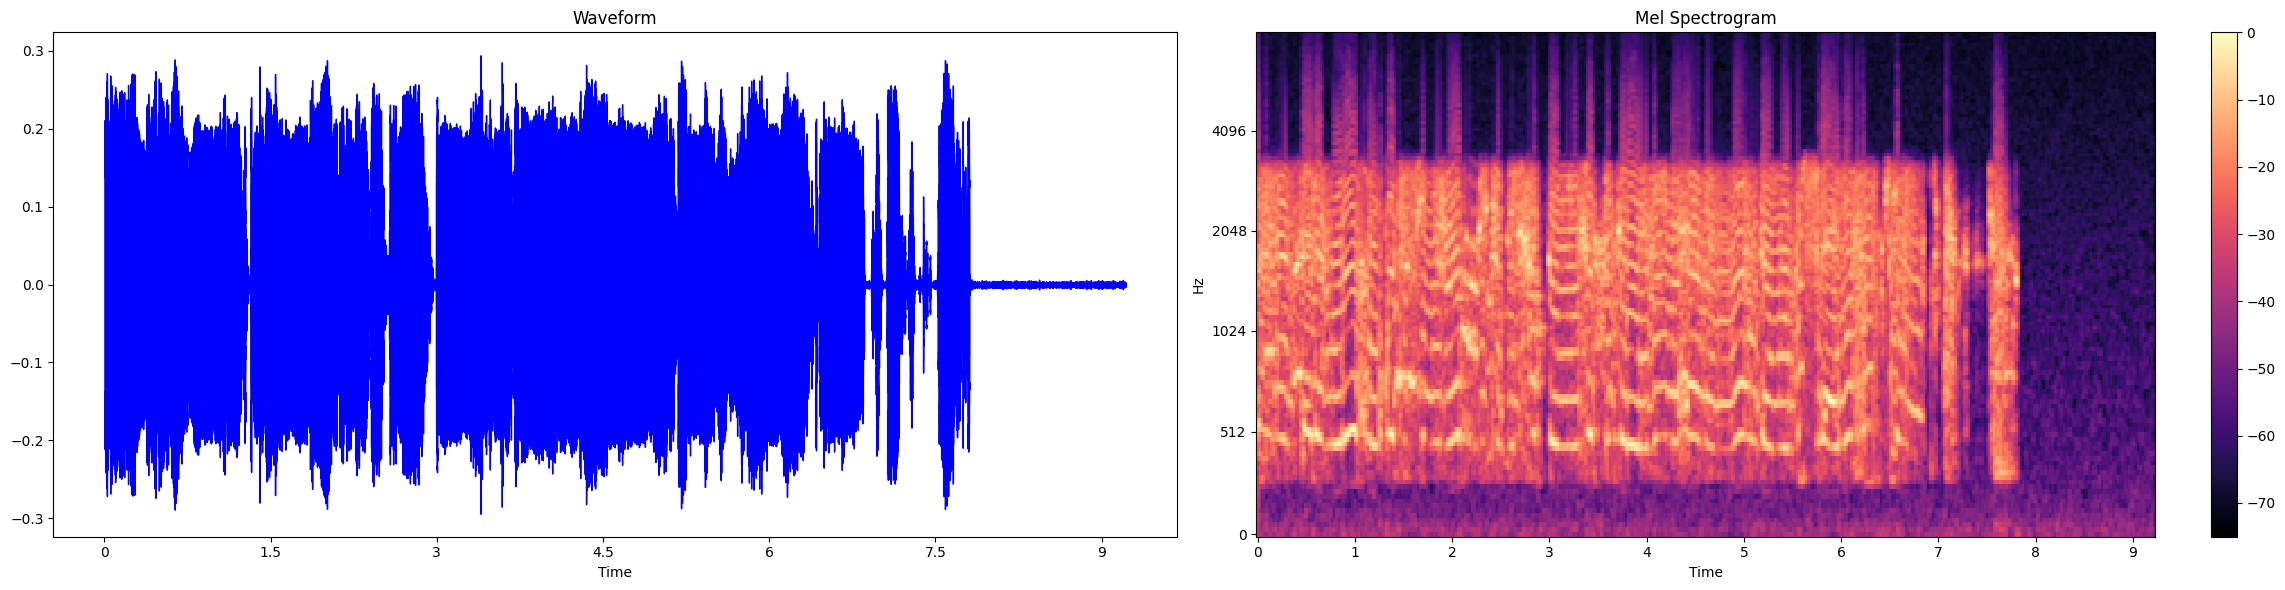

In [271]:
plot_utterance(other_utterance)

<span style="font-size: larger;"> What are the statistics for number of utterances per speaker?

In [272]:
speaker_counts = train_df['speaker'].value_counts()
# Convert to DataFrame
df_counts = speaker_counts.reset_index()

# Rename columns
df_counts.columns = ['speaker', 'num_utt_per_speaker']
fig = px.histogram(df_counts, x="num_utt_per_speaker", nbins=100, title='Histogram for number of utterances per speaker',
                   labels={'num_utt_per_speaker':'Utterances per Speaker'})
fig.show()

<h1 style="background-color:#4CAF50;"> <center> Using a Pre-Trained Speaker Embeddings Model </center> </h1>

- **ECAPA-TDNN (Emphasized Channel Attention, Propagation, and Aggregation in Time Delay Neural Network)** is a cutting-edge architecture for speaker recognition, enhancing traditional TDNN and x-vector models.

- It is a combination of convolutional and residual blocks.
- The embeddings are extracted using attentive statistical pooling
- The system is trained with Additive Margin Softmax Loss
- Speaker Verification is performed using cosine distance between speaker embeddings

<a href="https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.ECAPA_TDNN.html" target="_blank">Link to speechbrain documentation</a>

<a href="https://arxiv.org/pdf/2005.07143.pdf" target="_blank">Link to ECAPA-TDNN paper</a>


<span style="font-size: larger;"> Download the pre-trained ECAPA-TDNN model from **speechbrain**:

In [273]:
os.environ['SPEECHBRAIN_CACHE_DIR'] = "/home/eyalshw/github/wzudemy/hakol/data/cache"

In [274]:
class SpeechBrainEcapaPreTrained(nn.Module):

    def __init__(self):
        super(SpeechBrainEcapaPreTrained, self).__init__()

        self.classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device":"cuda"})
        self.classifier = self.classifier.to(DEVICE)

    def forward(self, x):
        x = x.to(DEVICE)
        emb = self.classifier.encode_batch(x)
        emb = torch.nn.functional.normalize(emb, dim=2)
        return emb.squeeze(1)



In [275]:
encoder = SpeechBrainEcapaPreTrained()

# TODO:
# replace encoder with our own
import nemo.collections.asr as nemo_asr
speaker_model_path = '/home/eyalshw/github/wzudemy/hakol/data/titanet-small_ft.nemo'
encoder = nemo_asr.models.EncDecSpeakerLabelModel.restore_from(speaker_model_path)





[NeMo W 2024-03-15 16:47:31 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /home/eyalshw/github/wzudemy/hakol/data/subset/nemo/filelist_manifest.json
    sample_rate: 16000
    labels:
    - '2533'
    - '3191'
    - '3363'
    - '4177'
    - '928'
    batch_size: 2
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor: null
    
[NeMo W 2024-03-15 16:47:31 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /home/eyalshw/github/wzudemy/hakol/data/subset/nemo/filelist_manifest.json
    sample_rate: 16000
    labels: null
    batc

[NeMo I 2024-03-15 16:47:31 features:289] PADDING: 16
[NeMo I 2024-03-15 16:47:31 save_restore_connector:249] Model EncDecSpeakerLabelModel was successfully restored from /home/eyalshw/github/wzudemy/hakol/data/titanet-small_ft.nemo.


In [276]:
encoder

EncDecSpeakerLabelModel(
  (loss): AngularSoftmaxLoss()
  (eval_loss): AngularSoftmaxLoss()
  (_accuracy): TopKClassificationAccuracy()
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(80, 80, kernel_size=(3,), stride=(1,), padding=(1,), groups=80, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(80, 256, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (3): SqueezeExcite(
            (fc): Sequential(
              (0): Linear(in_features=256, out_features=32, bias=False)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=32, out_features=256, bias=False)
            )
            (gap): AdaptiveAvgPool1d(output

In [277]:
def run_inference(utt_list, encoder):
    emb_arr = []
    for utt in utt_list:
        # signal, sr = torchaudio.load(utt)
        # signal = torchaudio.functional.resample(signal, orig_freq=sr, new_freq=TARGET_SR)
        # signal = signal.to(DEVICE)
        # signal_emb = encoder(signal)
        signal_emb = encoder.get_embedding(utt).squeeze()
        emb_arr.append(signal_emb)
    return torch.stack(emb_arr).squeeze(1)

In [278]:
# run_inference([])

### Let's look at the embedding space of some random speakers

In [279]:
def get_metadata(df, speaker_utts):

  combined_list = []
  for utt in speaker_utts:
    row = df[df['file'] == utt]
    combined_list.append(f"{row['noise_type'].item()}_{row['language'].item()}_{row['file'].item()}")

  return combined_list

In [280]:
# random_speakers = [1183, 2629, 320, 2924, 33]
random_speakers = random.sample(list(train_df['speaker'].unique()), 5)
labels          = []
embs            = []
utt_metadata    = []

for speaker in random_speakers:
    speaker_utts = train_df[train_df['speaker'] == speaker]['file'].values
    speaker_utts = random.sample(list(set(speaker_utts)), min(len(speaker_utts),20))
    utt_metadata.extend(get_metadata(train_df, speaker_utts))
    speaker_utts = [os.path.join(audio_files_path,f) for f in speaker_utts]
    embs.append(run_inference(speaker_utts, encoder))
    labels.extend([speaker] * len(speaker_utts))
embs = torch.vstack(embs).to('cpu')

### Reduce embedding dimensionality to 2D using UMAP - We do this for visualization only

In [281]:
umap_model  = umap.UMAP(n_components=2)
umap_result = umap_model.fit_transform(embs)

In [282]:
colors = [
    'rgb(255,0,0)',          # red
    'rgb(0,255,0)',          # green
    'rgb(0,0,255)',          # blue
    'rgb(255,255,0)',        # yellow
    'rgb(0,255,255)',        # cyan
]

def create_fig(labels, umap_result, utt_metadata, title):

    # Create a trace for each label
    traces = []
    unique_labels = np.unique(labels)
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        trace = go.Scatter(
            x=umap_result[mask, 0],
            y=umap_result[mask, 1],
            mode='markers',
            name=str(label),
            text=np.array(utt_metadata)[mask],  # Add utt_metadata as hover text
            hoverinfo='text',  # Show only text in hover
            line=dict(color=colors[idx])
        )
        traces.append(trace)

    # Create the plot
    layout = go.Layout(
        title='UMAP Visualization',
        xaxis=dict(title='UMAP Dimension 1'),
        yaxis=dict(title='UMAP Dimension 2'),
    )
    fig = go.Figure(data=traces, layout=layout)

    # Show the plot
    fig.update_layout(
        title=dict(text=f"{title}")
    )
    return fig

In [283]:
fig = create_fig(labels, umap_result, utt_metadata, title="Embeddings in 2D colored by the speaker")
fig.show()

### You can hover over a sample in the plot, get it's file and listen to it

In [284]:
Audio(os.path.join(audio_files_path, "7474942.wav"))

<span style="font-size: larger;"> Load the groups dataframe -
Each line holds an utterance file, it's group's id and the anchor speaker id.
<br/>**Important Note**: The file 'groups_challenge.csv' will be available only in the morning of the hackathon.<br/> From this cell on, you cannot run the notebook since you do not have groups_challenge.csv yet. You will get it on the day of the Hackathon.

In [285]:
os.path.exists(os.path.join(challenge_folder, 'groups_challenge.csv'))

True

In [286]:
groups_challenge_df = pd.read_csv(os.path.join(challenge_folder, 'groups_challenge.csv'))
groups_challenge_df.head(5)

,group_id,anchor_file,anchor_speaker,anchor_type,group_file,group_audio_speaker,group_audio_type,group_label
0,0,7122144.wav,4177,background,8287341.wav,4177,background,8287341.wav
1,1,1884556.wav,928,comm,3081309.wav,928,background,3081309.wav
2,2,6682928.wav,3363,comm,7474942.wav,3363,background,7474942.wav


<span style="font-size: larger;"> How many groups are there?

In [287]:
num_groups = len(groups_challenge_df['group_id'].unique())
print(f"The first challenge has {num_groups} groups")

The first challenge has 3 groups


<span style="font-size: larger;"> Inspect a random group

In [288]:
random_number = random.randint(0, num_groups)
df_group = groups_challenge_df[groups_challenge_df.group_id == random_number]
print(f"Inspecting group {random_number}")
anchor_file = df_group['anchor_file'].iloc[0]
print(f"The anchor file is: {anchor_file}")
anchor_type = df_group["anchor_type"].values.tolist()[0]
print(f"The anchor noise type is: {anchor_type}")
group_files = df_group["group_file"].values.tolist()

print(f"The group contains {len(group_files)} files")
print(f"The group files are: {group_files}")

Inspecting group 2
The anchor file is: 6682928.wav
The anchor noise type is: comm
The group contains 1 files
The group files are: ['7474942.wav']


<span style="font-size: larger;"> Listen to the anchor

In [289]:
Audio(os.path.join(audio_files_path,anchor_file))

<span style="font-size: larger;"> Listen to some random utterance from the group

In [290]:
Audio(os.path.join(audio_files_path,random.choice(group_files)))

<h1 style="background-color:#4CAF50;"> <center> Challenge Baseline Solution</center> </h1>

In [291]:
def submit_challenge_results(group_name, same_speaker_utt_lst):
    """
    Saves a list of selected utterances (one per group) into a CSV file that can be submitted for scoring.

    Parameters:
    - same_speaker_utt_lst (list): A list of utterances (files) identified as from the same speaker as the anchor in their group.
      Utterance in index k corresponds to the selected utterance of group k
    """
    # Convert the list to a DataFrame
    df = pd.DataFrame(same_speaker_utt_lst, columns=["same_speaker_utt"])

    # Write to CSV
    df.to_csv(f"{group_name}_results.csv", index=False)


In [292]:
def get_embeddings(anchor_file, group_utterances):
    """
    Generates embeddings for an anchor file and a group of utterances to compare against the anchor.

    This function prepares a batch for inference by first adding the anchor file to the beginning
    of the list of group utterances. It then constructs full paths for these files, runs the
    inference to get embeddings, and separates the embeddings of the anchor from the group.

    Parameters:
    - anchor_file (str): The file path of the anchor audio file.
    - group_utterances (list): A list of file paths for the group's utterances.

    Returns:
    - tuple: A tuple containing three elements:
        - anchor_emb (np.array): The embedding of the anchor file.
        - group_emb (list): A list of embeddings for the group utterances.
        - group_utterances (list): The original list of group utterances file paths,
          excluding the anchor file.
    """

    # Insert anchor_file as the first element for batch inference
    group_utterances.insert(0, anchor_file)

    # Construct full paths for each file in the group_utterances
    group_utterances_full = [os.path.join(audio_files_path, f) for f in group_utterances]

    # Run inference to get embeddings for the anchor and the group utterances
    all_emb = run_inference(group_utterances_full, encoder)

    # Separate the embeddings of the anchor from the group
    anchor_emb = all_emb[0]  # Embedding of the anchor file
    group_emb = all_emb[1:]  # Embeddings of the group utterances

    # Restore the original group_utterances list by removing the anchor file
    group_utterances = group_utterances[1:]

    return anchor_emb, group_emb, group_utterances


In [293]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)

def get_closest_speaker(anchor_emb, group_emb, group_utterances):
    """
    Identifies the utterance from a group that is closest to the anchor utterance based on cosine similarity.

    Parameters:
    - anchor_emb (torch.Tensor): The embedding vector of the anchor utterance.
    - group_emb (torch.Tensor):  A tensor of embedding vectors for the group utterances.
    - group_utterances (list):   A list of file paths for each utterance in the group.

    Returns:
    - str: The file path of the group utterance most similar to the anchor utterance.
    """
    distances = []
    # Compute cosine similarity between the anchor and each group utterance
    for i in range(group_emb.shape[0]):
        similarity = cosine_sim(anchor_emb, group_emb[i])  # Compute similarity
        distances.append(similarity.item())  # Convert tensor to Python scalar and append

    # Identify the index of the highest similarity score
    max_index = np.argmax(distances)

    # Retrieve the corresponding group utterance identifier
    same_speaker_utt = group_utterances[max_index]

    return same_speaker_utt

In [294]:
same_speaker_utt_lst = []

# Iterate through each group in the dataset
for group_id in tqdm(range(num_groups)):

    # Extract the dataframe for the current group
    group_df = groups_challenge_df[groups_challenge_df.group_id == group_id]

    # Retrieve the anchor file for the current group
    anchor_file = group_df['anchor_file'].iloc[0]

    # Collect all utterance files associated with the current group
    group_utterances = group_df['group_file'].values.tolist()

    # Obtain embeddings for the anchor and group utterances
    anchor_emb, group_emb, group_utterances = get_embeddings(anchor_file, group_utterances)

    # Determine the group utterance most similar to the anchor in embedding space
    same_speaker_utt = get_closest_speaker(anchor_emb, group_emb, group_utterances)

    # Append the identified utterance to the list of same speaker utterances
    same_speaker_utt_lst.append(same_speaker_utt)

# After processing all groups, submit the results
submit_challenge_results(group_name = hack_group_name, same_speaker_utt_lst=same_speaker_utt_lst)

100%|██████████| 3/3 [00:00<00:00, 15.53it/s]


<span style="font-size: larger;"> To summerize, the challenge here is **Cross Domain & Robust Speaker Recognition**

<h1 style="background-color:#4CAF50;"> <center> How can you test your work? </center> </h1>

You will be given **hackathon_train.csv** which contains the labeled utterances and **groups_challenge.csv** (anchors & groups) which is the testset. <br>Therefor, it is recommended that you split the train dataset into train & validation and **create your labeled validation-set** of anchors & groups.<br/> You will get a script which contains a basic implementation of this (which you are welcomed to modify in the hackathon). <br/> You will also get a script to help you score your work on the validation set.

<h1 style="background-color:#4CAF50;"> <center> What can you do from here? </center> </h1>

### This notebook contains a very basic solution which you can take to many different directions.
#### Here are some ideas (and we are sure there are many more...)
- **Clean the audio samples. Some possibilities are:**
    - Voice activity detection
    - Noise cancellation methods
    - Speech enhancement methods
- **Replace the speaker embedding model:**
    - Train your own model from scratch
    - Another better pre-trained model
    - Fine-tune a pre-trained model
    - Ensemble of models
- **Use domain adaptation methods**
- **Use signal processing methods**
- **...**



In [296]:
test = {}


In [297]:
test['222'] = 0


In [299]:
test['222']+=1

In [300]:
test

{'222': 1}

In [301]:
test['223']+=1

KeyError: '223'